In [17]:
# Task 4: Modeling Risk and Premiums for AlphaCare Insurance Solutions

# Step 1: Load and Prepare Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


# Load cleaned data (replace with your actual cleaned file if different)
df = pd.read_csv("cleaned_claims.csv")
df.head()
print(df.columns.tolist())


C:\Users\Dawa Cloud\AppData\Local\Temp\ipykernel_16604\1442518582.py:16: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cleaned_claims.csv")


['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'HasClaimed', 'Age', 'has_claim']


In [18]:
# Optional: Remove rows with negative claim amounts (already done if you're here)
df = df[df['TotalClaims'] >= 0]

# Target variable
df['has_claim'] = df['TotalClaims'].apply(lambda x: 1 if x > 0 else 0)

# Drop irrelevant or high-cardinality columns
drop_cols = ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'PostalCode', 'Model', 
             'make', 'SubCrestaZone', 'VehicleIntroDate', 'mmcode']
df_model = df.drop(columns=drop_cols, errors='ignore')

# Select numerical + categorical features
features = ['Age', 'Gender', 'Province', 'VehicleType', 'RegistrationYear', 'cubiccapacity', 
            'kilowatts', 'bodytype', 'NumberOfDoors', 'CustomValueEstimate', 'CapitalOutstanding', 
            'NewVehicle', 'Rebuilt', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 
            'TotalPremium', 'CoverType', 'Section', 'Product', 'StatutoryClass', 
            'StatutoryRiskType', 'CalculatedPremiumPerTerm']

df_model = df_model[features + ['has_claim']].dropna()

# Encode categoricals
for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])


In [20]:
df_model = df_model[features + ['has_claim']]
print("Before dropping NaNs:", df_model.shape)
df_model = df_model.dropna()
print("After dropping NaNs:", df_model.shape)


Before dropping NaNs: (0, 24)
After dropping NaNs: (0, 24)


In [21]:
print(df['has_claim'].value_counts())


has_claim
0    986794
1      2760
Name: count, dtype: int64


In [23]:
df_model = df[features + ['has_claim']].copy()

# Drop columns with more than 50% missing
df_model = df_model.dropna(thresh=len(df_model) * 0.5, axis=1)

# Fill missing values
for col in df_model.columns:
    if df_model[col].dtype == 'object':
        df_model[col] = df_model[col].fillna(df_model[col].mode()[0])
    else:
        df_model[col] = df_model[col].fillna(df_model[col].median())

# Label encode categorical features
from sklearn.preprocessing import LabelEncoder


for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))




In [24]:
from sklearn.model_selection import train_test_split

X = df_model.drop('has_claim', axis=1)
y = df_model['has_claim']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression with class weight
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

# Random Forest with class weight
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


e:\Kifya\ACIS-insurance-risk-analysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    296039
           1       0.01      0.78      0.02       828

    accuracy                           0.79    296867
   macro avg       0.50      0.79      0.45    296867
weighted avg       1.00      0.79      0.88    296867

Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    296039
           1       0.02      0.32      0.03       828

    accuracy                           0.95    296867
   macro avg       0.51      0.63      0.50    296867
weighted avg       1.00      0.95      0.97    296867



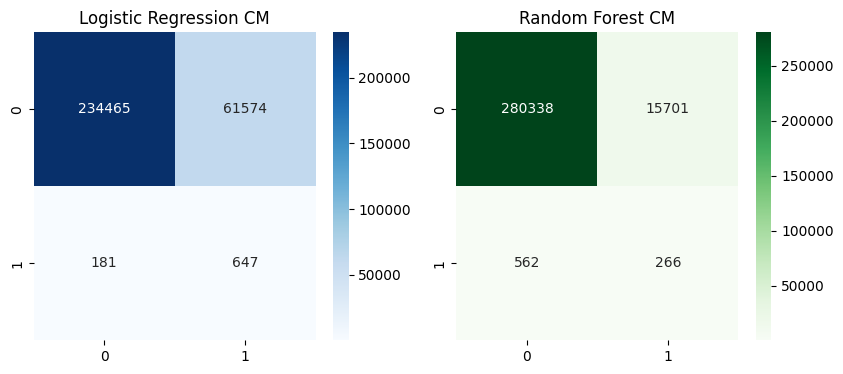

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# Random Forest
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression CM")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest CM")
plt.show()



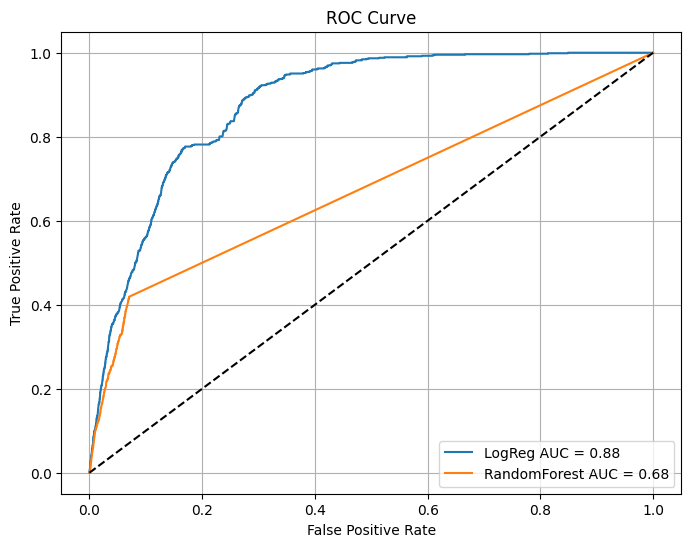

In [28]:
# Predict probabilities
y_prob_lr = lr.predict_proba(X_test)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]

# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg AUC = {roc_auc_score(y_test, y_prob_lr):.2f}")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest AUC = {roc_auc_score(y_test, y_prob_rf):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


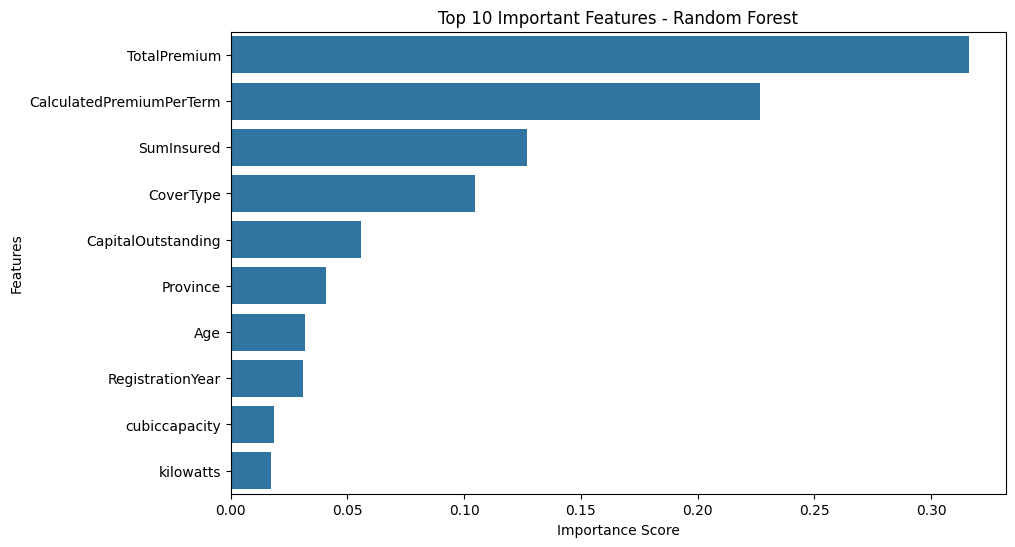

In [29]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [30]:
from xgboost import XGBClassifier

# Create the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)


e:\Kifya\ACIS-insurance-risk-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:43:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


e:\Kifya\ACIS-insurance-risk-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Kifya\ACIS-insurance-risk-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Kifya\ACIS-insurance-risk-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    296039
           1       0.00      0.00      0.00       828

    accuracy                           1.00    296867
   macro avg       0.50      0.50      0.50    296867
weighted avg       0.99      1.00      1.00    296867

Confusion Matrix:
 [[296039      0]
 [   828      0]]


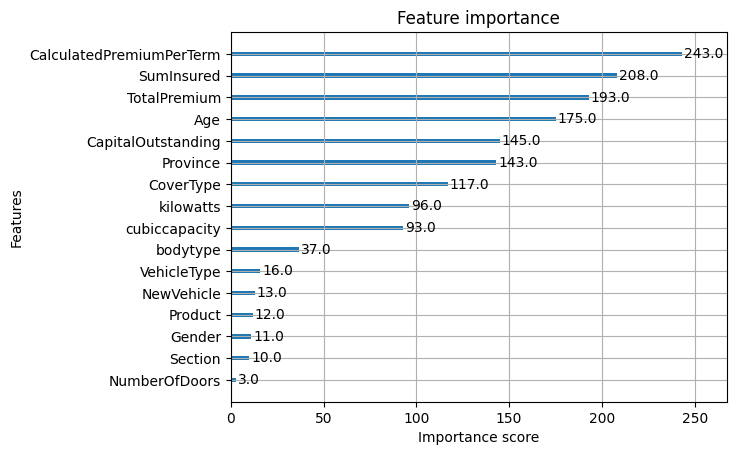

In [32]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot top 20 features
plot_importance(xgb_model, max_num_features=20)
plt.show()
